In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from pylab import rcParams

In [5]:
# Upload datasets
datasets = {}
datasets["oil"] = pd.read_csv("data/oil.csv")
datasets["stores"] = pd.read_csv("data/stores.csv")
datasets["train"] = pd.read_csv("data/train.csv")
datasets["test"] = pd.read_csv("data/test.csv")
datasets["transactions"] = pd.read_csv("data/transactions.csv")
datasets["holidays"] = pd.read_csv("data/holidays_events.csv")

In [6]:
# Transform rows to datetime
for _, dataset in datasets.items():
    if "date" in dataset.columns:
        dataset["date"] = pd.to_datetime(dataset["date"])

In [11]:
family = "GROCERY I"
sales_per_day = datasets["train"][datasets["train"]["family"] == family].groupby(datasets["train"]['date'].dt.date).sum()["sales"]

sales_per_day



date
2013-01-01       700.000
2013-01-02    202020.000
2013-01-03    144878.000
2013-01-04    135754.000
2013-01-05    188356.000
                 ...    
2017-08-11    238221.922
2017-08-12    238627.633
2017-08-13    258442.452
2017-08-14    225355.694
2017-08-15    224208.125
Name: sales, Length: 1684, dtype: float64

### Additive descomposition

<Figure size 1440x4320 with 0 Axes>

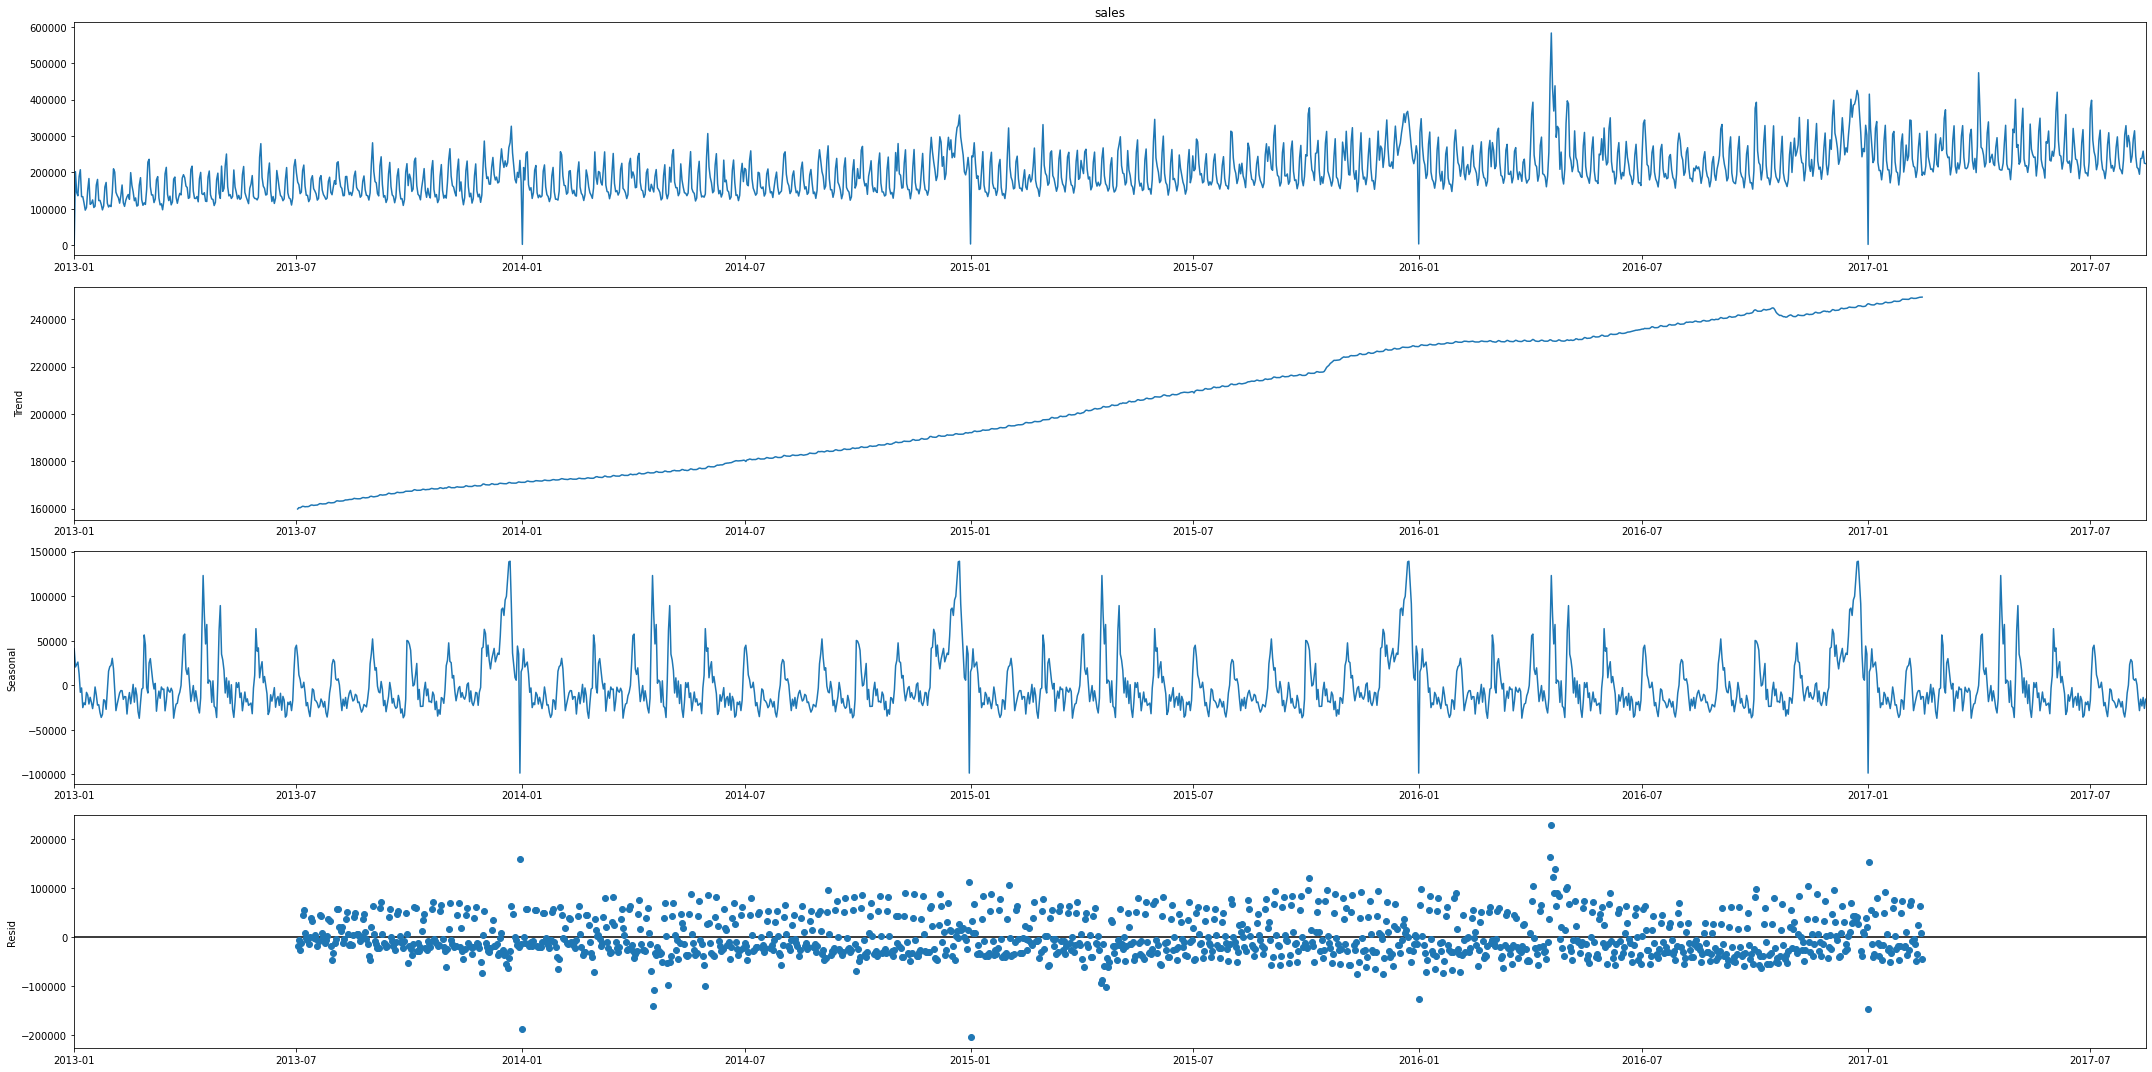

<Figure size 1440x4320 with 0 Axes>

In [26]:
result = seasonal_decompose(sales_per_day, model='additive', period=365)
 
rcParams['figure.figsize'] = 30, 15
result.plot()
plt.figure(figsize=(20, 60))

### Multiplicative descomposition

<Figure size 1440x4320 with 0 Axes>

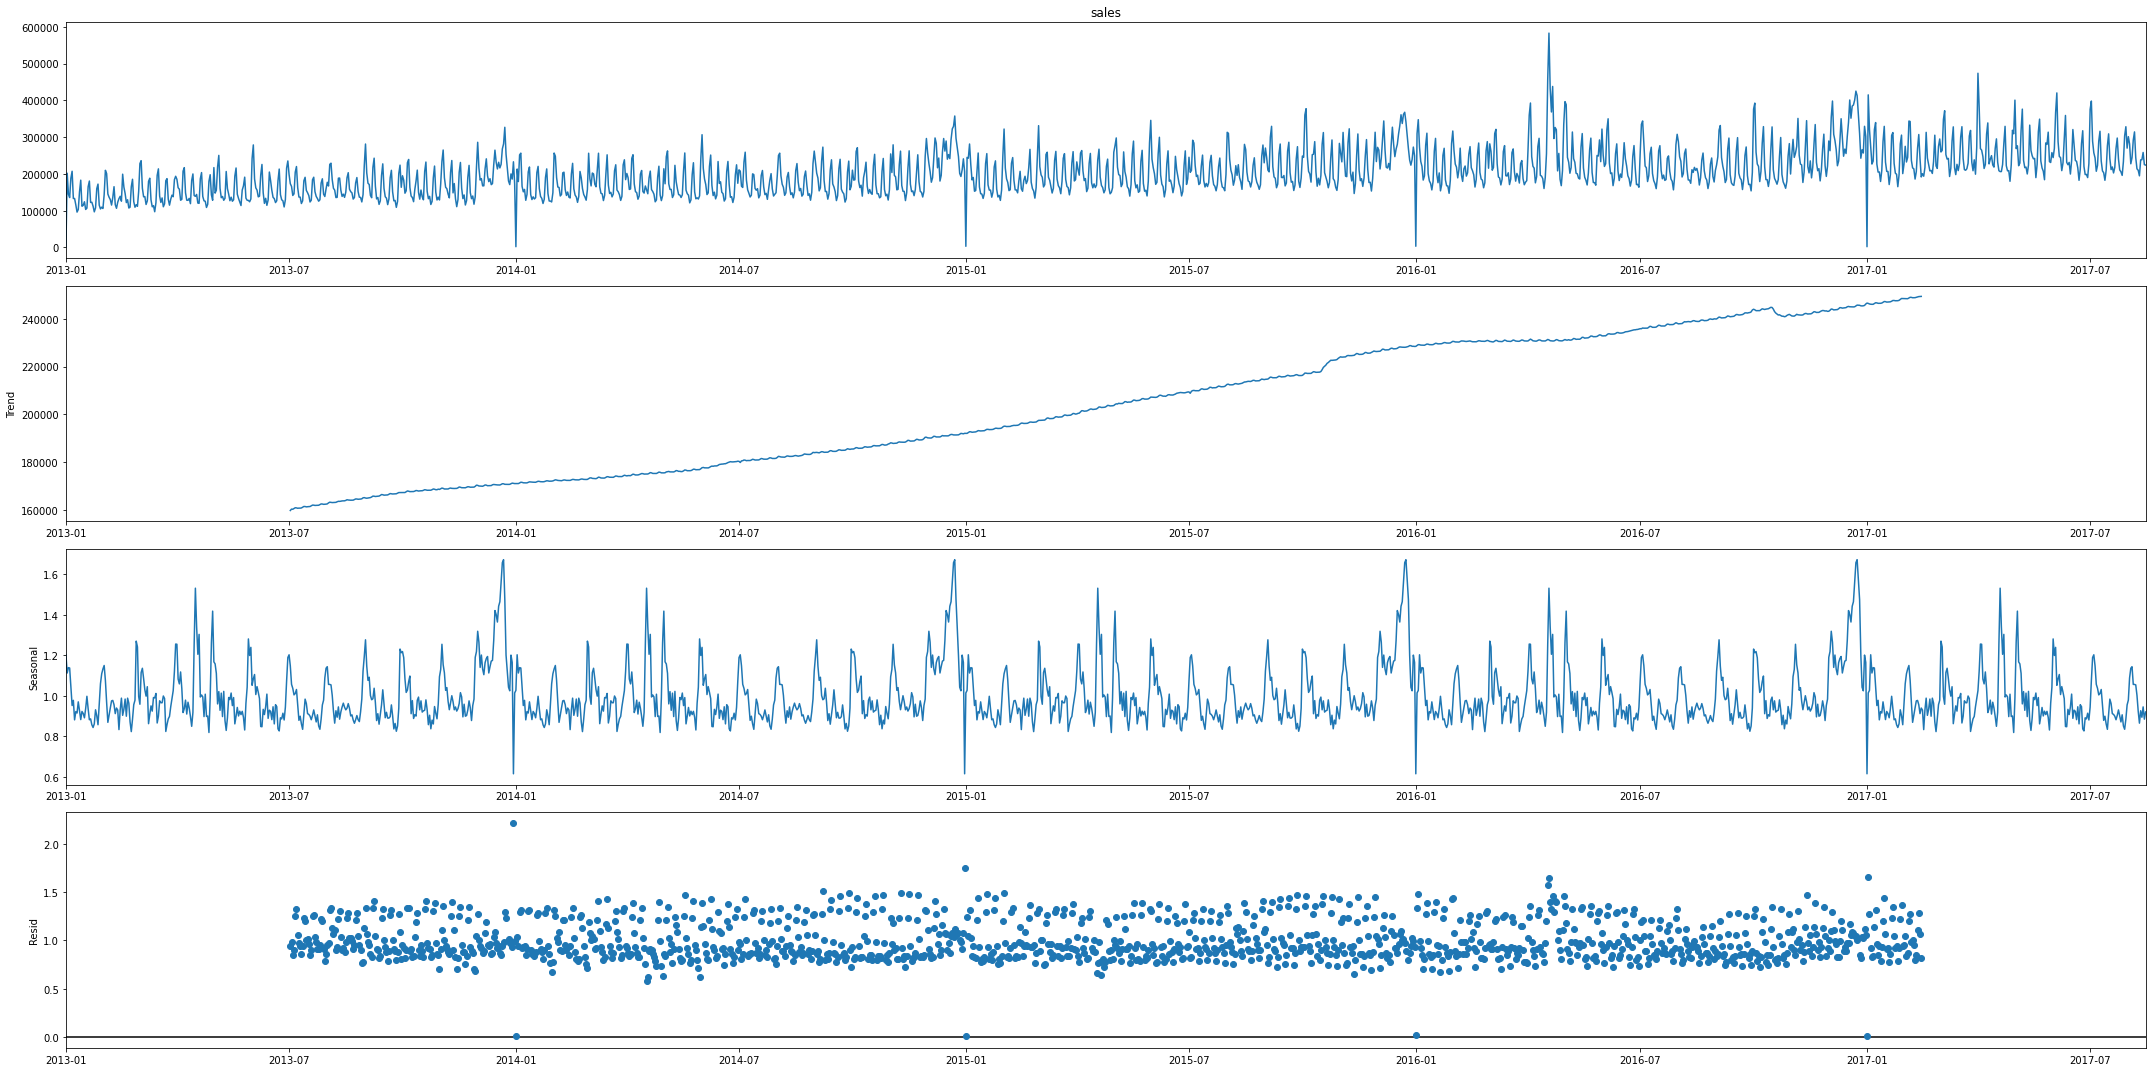

<Figure size 1440x4320 with 0 Axes>

In [25]:
result = seasonal_decompose(sales_per_day, model='multiplicative', period=365)
 
rcParams['figure.figsize'] = 30, 15
result.plot()
plt.figure(figsize=(20, 60))